# Simulate stochastic process

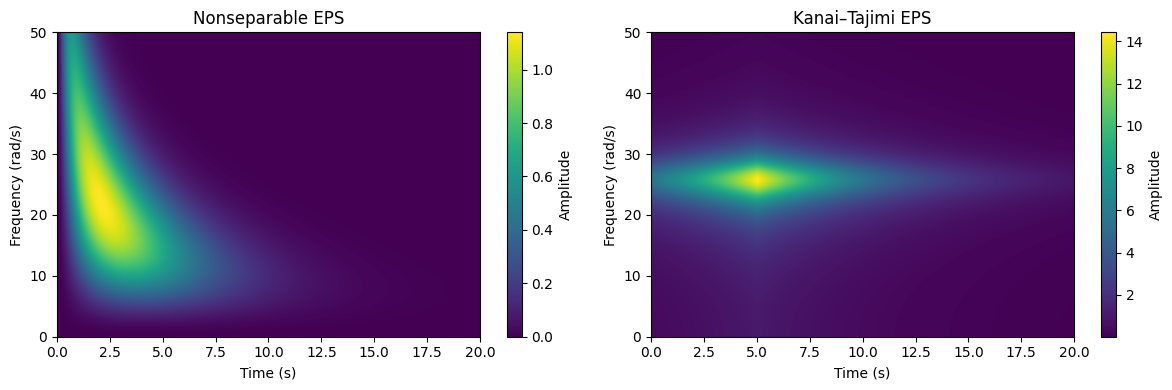

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from eps.nonsep import nonseparable_evolutionary_power_spectrum
from eps.kt import kt_evolutionary_power_spectrum

time = np.linspace(0, 20, 512)
freq = np.linspace(0, 50, 512)

X, Y = np.meshgrid(time, freq)

eps_cp = np.zeros((len(time), len(freq)))
eps_kt = np.zeros((len(time), len(freq)))

#EPSs parameters
S0 = 1
b0 = 0.47500000000000003

#KT parameter
omega_g = 26.25
zeta_g = 0.1375

for i in range(len(time)):
    for j in range(len(freq)):
        eps_cp[i][j] = nonseparable_evolutionary_power_spectrum(freq[j], time[i], S0, b0)
        eps_kt[i][j] = kt_evolutionary_power_spectrum(freq[j], time[i], S0, omega_g, zeta_g, b0, 5)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

im0 = axes[0].imshow(
    eps_cp.T,                  # transpose so freq is y-axis
    extent=[time.min(), time.max(), freq.min(), freq.max()],
    origin='lower',
    aspect='auto',
    cmap=cm.viridis
)
axes[0].set_title("Nonseparable EPS")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Frequency (rad/s)")
fig.colorbar(im0, ax=axes[0], label="Amplitude")

im1 = axes[1].imshow(
    eps_kt.T,                  # transpose so freq is y-axis
    extent=[time.min(), time.max(), freq.min(), freq.max()],
    origin='lower',
    aspect='auto',
    cmap=cm.viridis
)
axes[1].set_title("Kanai–Tajimi EPS")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Frequency (rad/s)")
fig.colorbar(im1, ax=axes[1], label="Amplitude")

plt.tight_layout()
plt.show()

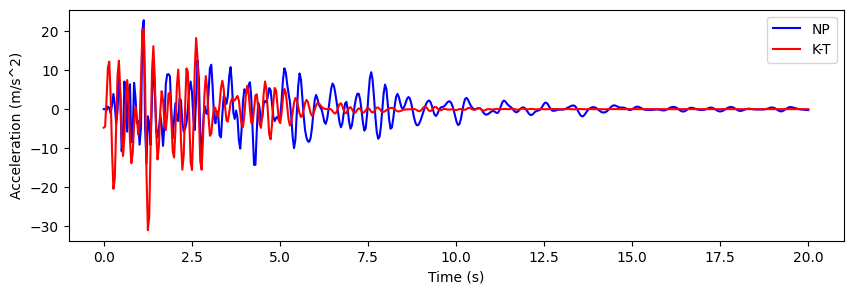

In [80]:
from simulate_process import simulate_process
import pandas as pd

w_cp = np.zeros((200, len(time)))
w_kt = np.zeros((200, len(time)))

for i in range(w_cp.shape[0]):
    w_cp[i,:] = simulate_process(time, S0, max(freq), omega_g, zeta_g, b0)
    w_kt[i,:] = simulate_process(time, S0, omega_g, omega_g, zeta_g, b0, eps_type='kt')

fig = plt.figure(figsize=(10,3))

plt.plot(time, w_cp[10,:], 'b')
plt.plot(time, w_kt[10,:], 'r')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.legend(['NP', 'K-T'])
plt.show()

w_cp_df = pd.DataFrame(w_cp.T).add_prefix('cp_')
w_kt_df = pd.DataFrame(w_kt.T).add_prefix('kt_')

df_results = pd.concat([w_cp_df, w_kt_df], axis=1)
df_results['time'] = time
df_results.to_csv(f'data/realizations/stochastic_process_{S0}_{b0}_{omega_g}_{zeta_g}.csv', index=False)

# GHW

In [81]:
import numpy as np
import pandas as pd
from wavelet.get_band_options import ghw_band_options

df = pd.read_csv(f'data/realizations/stochastic_process_{S0}_{b0}_{omega_g}_{zeta_g}.csv')

t = df["time"].values
x = df["cp_1"].values

dt = np.diff(t)
fs = 1.0 / np.median(dt)
print(f"Estimated fs = {fs:.2f} Hz")
print(f"Max dt = {max(dt):.4f} s")

# bands
bins_per_band = 4
uniform_bands, adaptive_bands, freqs = ghw_band_options(x, fs, bins_per_band=bins_per_band, spike_prominence=1e-1)

Estimated fs = 25.55 Hz
Max dt = 0.0391 s


In [82]:
from wavelet.ghw_transform import ghw_transform

# Apply GHW
out_uniform = ghw_transform(x, fs, uniform_bands, analytic=True, return_downsampled=False)
out_adaptive = ghw_transform(x, fs, adaptive_bands, analytic=True, return_downsampled=False)

# Extract coefficients and bands from ghw_transform output
coeffs = out_uniform["complex"]    # list of arrays per band
bands = out_uniform["bands"]       # (flo, fhi) Hz

num_bands = len(coeffs)

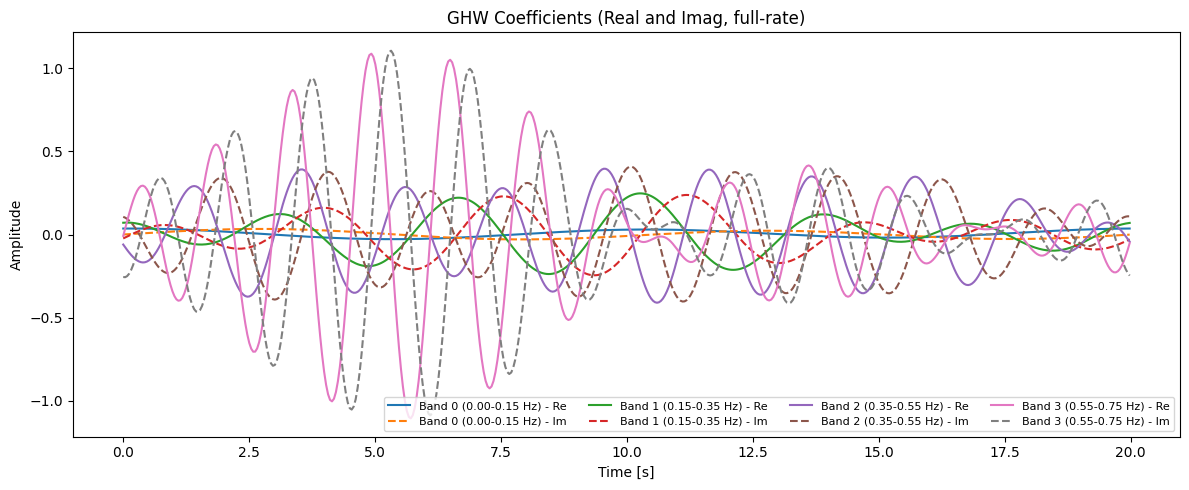

In [83]:
import numpy as np
import matplotlib.pyplot as plt

time = np.linspace(0, 40, 1024)
dt = time[1] - time[0]
t_original = np.arange(len(x)) * dt

plt.figure(figsize=(12,5))
n_bands_to_plot = 4 

for i in range(min(n_bands_to_plot, len(coeffs))):
    c = coeffs[i]
    plt.plot(t_original, c.real, label=f"Band {i} ({bands[i,0]:.2f}-{bands[i,1]:.2f} Hz) - Re")
    plt.plot(t_original, c.imag, "--", label=f"Band {i} ({bands[i,0]:.2f}-{bands[i,1]:.2f} Hz) - Im")

plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("GHW Coefficients (Real and Imag, full-rate)")
plt.legend(fontsize=8, ncol=n_bands_to_plot)
plt.tight_layout()
plt.show()

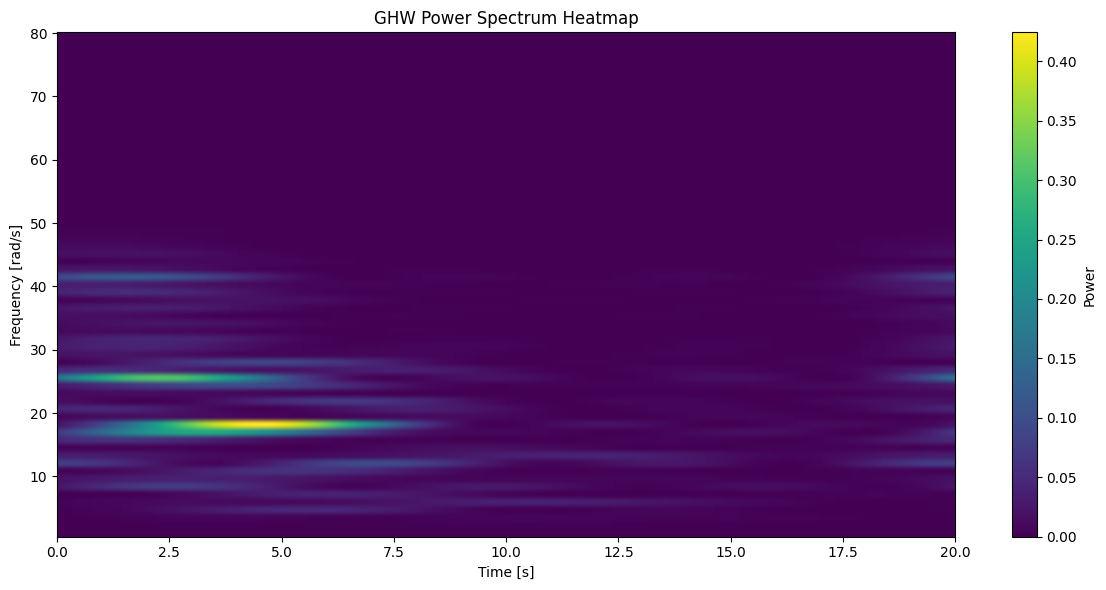

In [84]:
import numpy as np
import matplotlib.pyplot as plt

time = np.linspace(0,20,512)
power_matrix = np.array([np.abs(c)**2/(2*np.pi*4) for c in coeffs])
freq_centers = 2*np.pi*np.array([(b[0]+b[1])/2 for b in bands])

plt.figure(figsize=(12,6))
plt.imshow(power_matrix, aspect='auto', origin='lower',
           extent=[time[0], time[-1], freq_centers[0], freq_centers[-1]])
plt.colorbar(label='Power')
plt.xlabel("Time [s]")
plt.ylabel("Frequency [rad/s]")
plt.title("GHW Power Spectrum Heatmap")
plt.tight_layout()
plt.show()

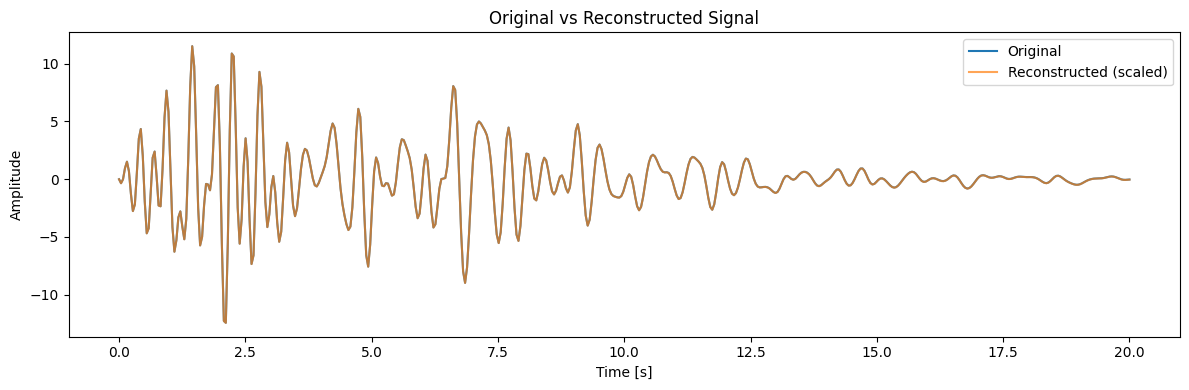

In [67]:
x_rec = out_uniform["reconstruct_fullrate"]()

# Scale to match original signal RMS
scale = np.std(x) / np.std(x_rec)
x_rec_scaled = x_rec * scale

plt.figure(figsize=(12,4))
plt.plot(time, x, label="Original")
plt.plot(time, x_rec_scaled, label="Reconstructed (scaled)", alpha=0.7)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Original vs Reconstructed Signal")
plt.legend()
plt.tight_layout()
plt.show()


# Get coef

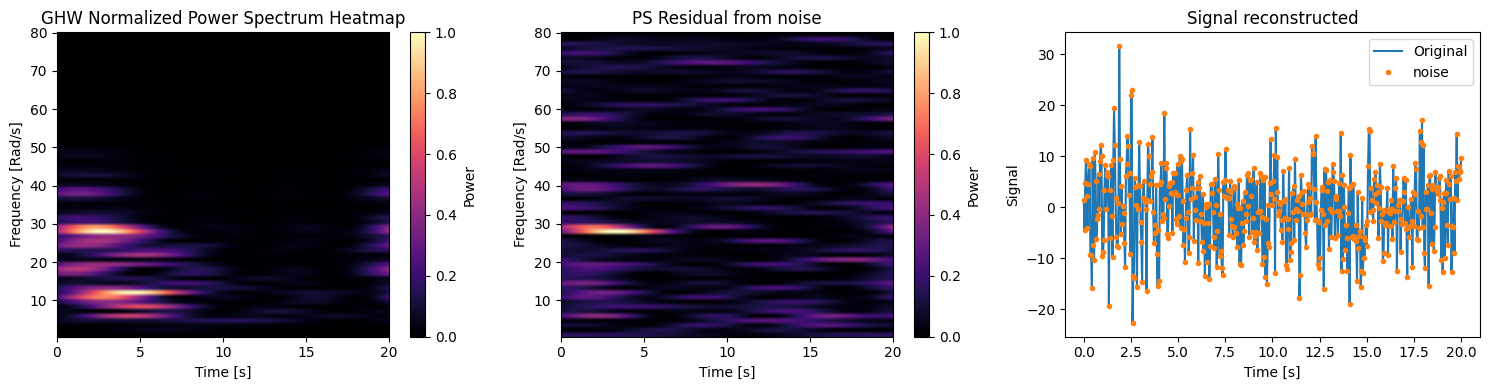

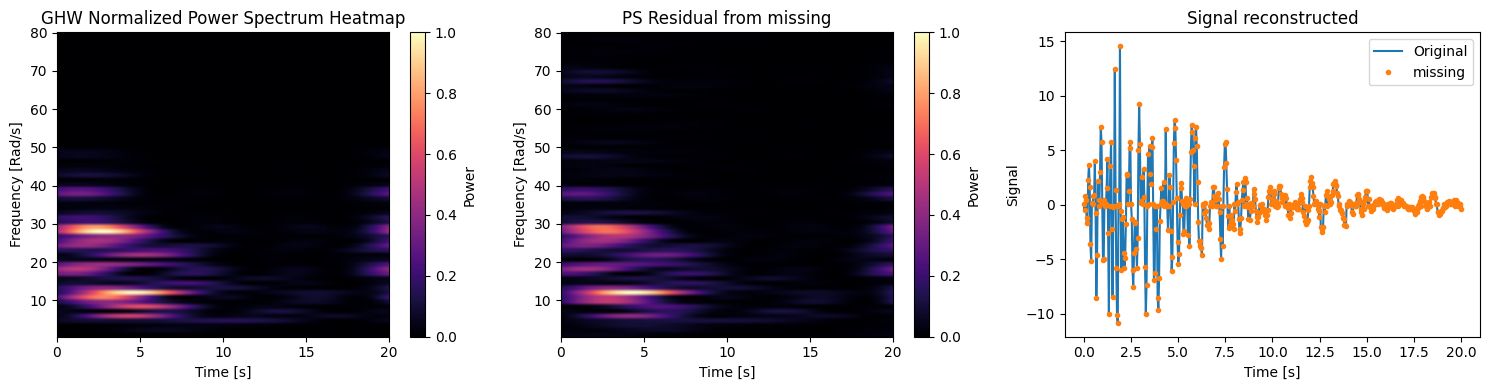

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_power(df: pd.DataFrame, df_aux = None, tmax: float = 20, timesteps: int = 512, width = 4, df_type = None): 
    time = np.linspace(0, tmax, timesteps)
    freq_centers = 2*np.pi*df['freq_centers'].values
    coeffs = df.drop(columns='freq_centers')
    power_matrix = np.array([np.abs(c)**2/(2*np.pi*width) for c in coeffs.values])
    normalized_power_matrix = (power_matrix - power_matrix.min()) / (power_matrix.max() - power_matrix.min())

    if df_aux is not None:
        coeffs_aux = coeffs = df_aux.drop(columns='freq_centers')
        power_matrix_aux = np.array([np.abs(coeffs_aux)**2/(2*np.pi*width) for coeffs_aux in coeffs_aux.values])
        normalized_power_matrix_aux = (power_matrix_aux - power_matrix_aux.min()) / (power_matrix_aux.max() - power_matrix_aux.min())

    if df_aux is None:
        fig = plt.figure(figsize=(8,4))
        plt.subplot(1,2,1)
        plt.imshow(normalized_power_matrix, aspect='auto', origin='lower', extent=[time[0], time[-1], freq_centers[0], freq_centers[-1]], cmap='magma')
        plt.colorbar(label='Power')
        plt.xlabel("Time [s]")
        plt.ylabel("Frequency [Rad/s]")
        plt.title("GHW Normalized Power Spectrum Heatmap")

        plt.subplot(1,2,2)
        reconstructed_signal = np.sum(coeffs.values.real, axis=0)
        plt.plot(time, reconstructed_signal)
        plt.xlabel("Time [s]")
        plt.ylabel("Signal")
        plt.title("Signal reconstructed")

    else:
        fig = plt.figure(figsize=(15,4))
        plt.subplot(1,3,1)
        plt.imshow(normalized_power_matrix, aspect='auto', origin='lower', extent=[time[0], time[-1], freq_centers[0], freq_centers[-1]], cmap='magma')
        plt.colorbar(label='Power')
        plt.xlabel("Time [s]")
        plt.ylabel("Frequency [Rad/s]")
        plt.title("GHW Normalized Power Spectrum Heatmap")

        plt.subplot(1,3,2)
        plt.imshow(np.abs(normalized_power_matrix_aux), aspect='auto', origin='lower', extent=[time[0], time[-1], freq_centers[0], freq_centers[-1]], cmap='magma')
        plt.colorbar(label='Power')
        plt.xlabel("Time [s]")
        plt.ylabel("Frequency [Rad/s]")
        plt.title(f"PS Residual from {df_type}")

        plt.subplot(1,3,3)
        reconstructed_signal = np.sum(coeffs.values.real, axis=0)
        reconstructed_signal_aux = np.sum(coeffs_aux.values.real, axis=0)
        plt.plot(time, reconstructed_signal)
        plt.plot(time, reconstructed_signal_aux, '.')
        plt.legend(['Original', f'{df_type}'])
        plt.xlabel("Time [s]")
        plt.ylabel("Signal")
        plt.title("Signal reconstructed")

    plt.tight_layout()
    plt.show()

base = 'stochastic_process_0.5_0.4_20.0_0.1_freq_cp_50.0_freq_kt_20.0_cp_13'

filename = f'data/transformations/{base}.pkl'
df : pd.DataFrame = pd.read_pickle(filename)
filename = f'data/transformations/{base}_noisy.pkl'
df_noisy : pd.DataFrame = pd.read_pickle(filename)
filename = f'data/transformations/{base}_missing.pkl'
df_missing: pd.DataFrame = pd.read_pickle(filename)

plot_power(df, df_noisy, df_type='noise')
plot_power(df, df_missing, df_type='missing')


# CAE

In [139]:
import os

def get_files_in_directory(directory_path):
    """
    Returns a list of files in the specified directory (non-recursive).
    """
    all_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) 
                 if os.path.isfile(os.path.join(directory_path, f))]
    return all_files

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SymmetricCAE(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),   # 64x512 -> 32x256
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # 32x256 -> 16x128
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # 16x128 -> 8x64
            nn.ReLU(True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), # 8x64 -> 4x32
            nn.ReLU(True)
        )

        self.flatten = nn.Flatten()
        self.encoder_fc = nn.Linear(128*4*32, latent_dim)

        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, 128*4*32)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=(0,0)), # 4x32 -> 8x64
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=(0,0)),  # 8x64 -> 16x128
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=(0,0)),  # 16x128 -> 32x256
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=(0,0)),   # 32x256 -> 64x512
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        z_flat = self.flatten(z)
        z_latent = self.encoder_fc(z_flat)

        x_hat_flat = self.decoder_fc(z_latent)
        x_hat = x_hat_flat.view(z.size())
        x_hat = self.decoder(x_hat)

        # Ensure exact size (safeguard)
        x_hat = F.interpolate(x_hat, size=x.shape[2:], mode='bilinear', align_corners=False)

        return x_hat, z_latent
    
class EarlyStopping:
    def __init__(self, patience=5, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [3]:
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import pandas as pd
from tqdm import tqdm

files = get_files_in_directory('data/transformations')
data_list = []

for i in tqdm(files):
    df : pd.DataFrame = pd.read_pickle(i)
    df = df[:-1]

    width = 4
    coeffs = df.drop(columns='freq_centers')

    power_matrix = np.array([np.abs(c)**2/(2*np.pi*width) for c in coeffs.values])
    normalized_power_matrix = (power_matrix - power_matrix.min()) / (power_matrix.max() - power_matrix.min())

    data_list.append(normalized_power_matrix)

data = np.stack(data_list)
data = data[:, np.newaxis, :, :]
data = torch.tensor(data, dtype=torch.float32)
data = TensorDataset(data)

train_size = int(0.8 * len(data))
val_size = len(data) - train_size
train_dataset, val_dataset = random_split(data, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

100%|██████████| 44400/44400 [00:38<00:00, 1164.25it/s]


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SymmetricCAE(latent_dim=256).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
criterion = nn.MSELoss()

num_epochs = 100
early_stopping = EarlyStopping(patience=10, min_delta=1e-5)

for epoch in range(num_epochs):
    # --- Training ---
    model.train()
    train_loss = 0
    for batch in train_loader:
        x = batch[0].to(device)
        optimizer.zero_grad()
        x_hat, z = model(x)
        loss = criterion(x_hat, x)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
    train_loss /= len(train_loader.dataset)
    
    # --- Validation ---
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            x = batch[0].to(device)
            x_hat, z = model(x)
            loss = criterion(x_hat, x)
            val_loss += loss.item() * x.size(0)
    val_loss /= len(val_loader.dataset)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.6f}  Val Loss: {val_loss:.6f}")
    
    # Early stopping check
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break

Epoch [1/100] Train Loss: 0.012132  Val Loss: 0.004570
Epoch [2/100] Train Loss: 0.003631  Val Loss: 0.003053
Epoch [3/100] Train Loss: 0.002757  Val Loss: 0.002472
Epoch [4/100] Train Loss: 0.002131  Val Loss: 0.001874
Epoch [5/100] Train Loss: 0.001670  Val Loss: 0.001501
Epoch [6/100] Train Loss: 0.001361  Val Loss: 0.001277
Epoch [7/100] Train Loss: 0.001200  Val Loss: 0.001144
Epoch [8/100] Train Loss: 0.001106  Val Loss: 0.001073
Epoch [9/100] Train Loss: 0.001051  Val Loss: 0.001033
Epoch [10/100] Train Loss: 0.001008  Val Loss: 0.001003
Epoch [11/100] Train Loss: 0.000977  Val Loss: 0.000971
Epoch [12/100] Train Loss: 0.000958  Val Loss: 0.000954
Epoch [13/100] Train Loss: 0.000943  Val Loss: 0.000940
Epoch [14/100] Train Loss: 0.000933  Val Loss: 0.000929
Epoch [15/100] Train Loss: 0.000924  Val Loss: 0.000921
Epoch [16/100] Train Loss: 0.000917  Val Loss: 0.000911
Epoch [17/100] Train Loss: 0.000910  Val Loss: 0.000914
Epoch [18/100] Train Loss: 0.000907  Val Loss: 0.000908
E

/tmp/ipykernel_15580/976492288.py:32: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  error = np.abs((np.array((a-b)))).max()
/tmp/ipykernel_15580/976492288.py:34: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  print(np.abs(a).max())


0.27314436
tensor(1.)
0.48723757
tensor(1.)
0.32532507
tensor(1.)


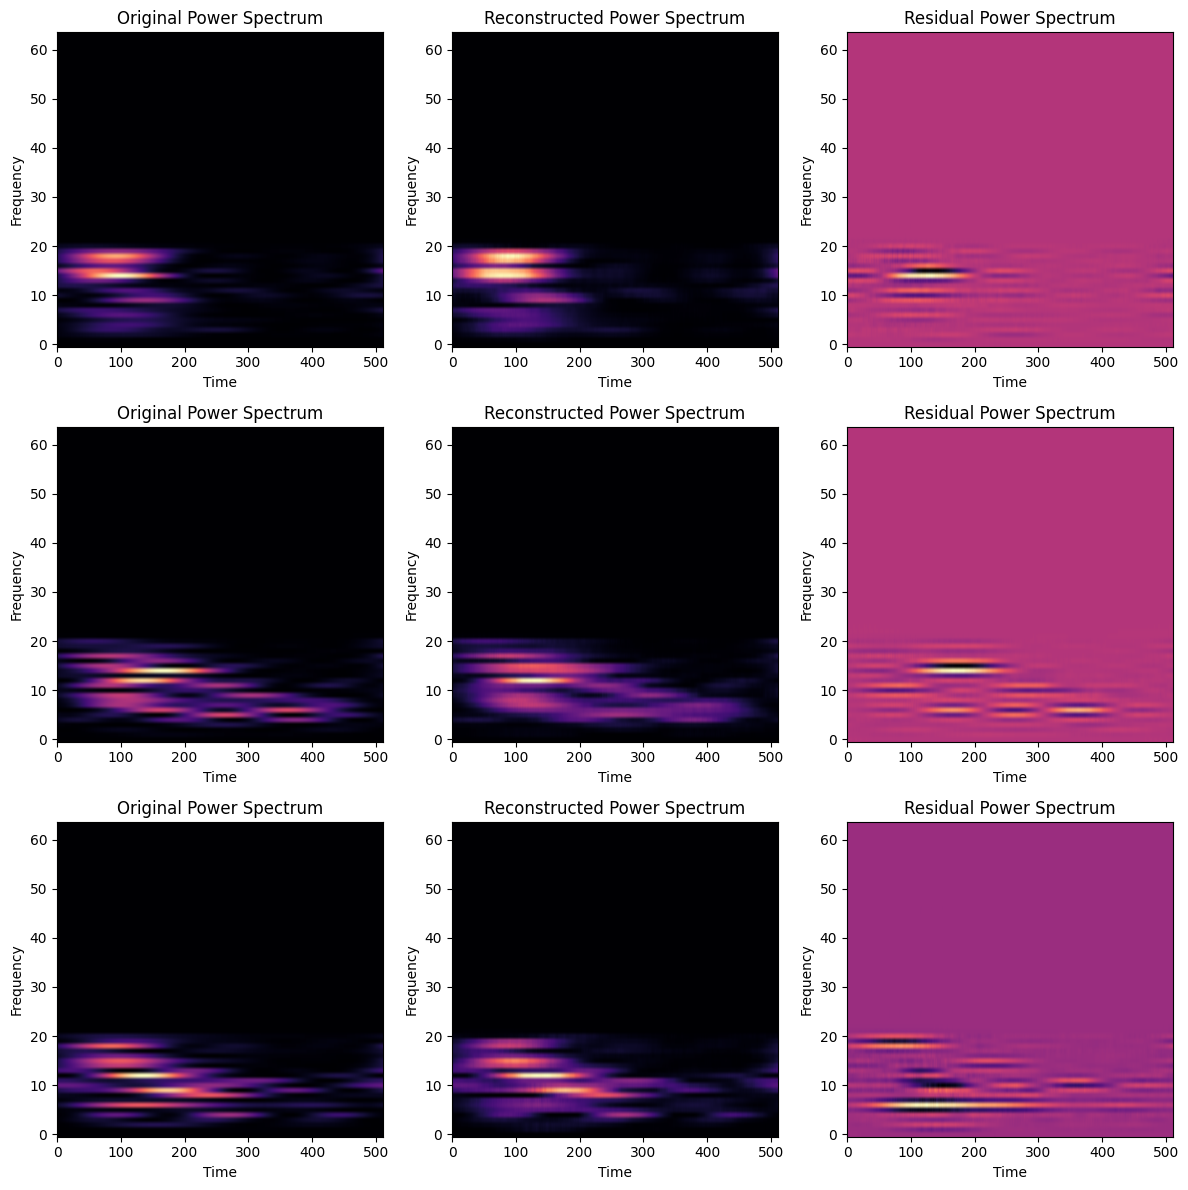

In [ ]:
import matplotlib.pyplot as plt

model.eval()
val_iter = iter(val_loader)
x_val_batch = next(val_iter)[0].to(device)  # Get a batch of validation samples
x_hat_val, z = model(x_val_batch)          # Reconstructed batch

num_examples = 3  # how many to visualize
fig, axes = plt.subplots(num_examples, 3, figsize=(12, 4*num_examples))

for i in range(num_examples):
    # Original
    axes[i,0].imshow(x_val_batch[i,0].cpu(), aspect='auto', origin='lower', cmap='magma')
    axes[i,0].set_title("Original Power Spectrum")
    axes[i,0].set_xlabel("Time")
    axes[i,0].set_ylabel("Frequency")
    
    # Reconstruction
    axes[i,1].imshow(x_hat_val[i,0].detach().cpu(), aspect='auto', origin='lower', cmap='magma')
    axes[i,1].set_title("Reconstructed Power Spectrum")
    axes[i,1].set_xlabel("Time")
    axes[i,1].set_ylabel("Frequency")

    # Reconstruction
    axes[i,2].imshow(x_val_batch[i,0].cpu() - x_hat_val[i,0].detach().cpu(), aspect='auto', origin='lower', cmap='magma')
    axes[i,2].set_title("Residual Power Spectrum")
    axes[i,2].set_xlabel("Time")
    axes[i,2].set_ylabel("Frequency")

    a = x_val_batch[i,0].cpu()
    b = x_hat_val[i,0].detach().cpu()
    error = np.abs((np.array((a-b)))).max()
    print(error)

plt.tight_layout()
plt.show()

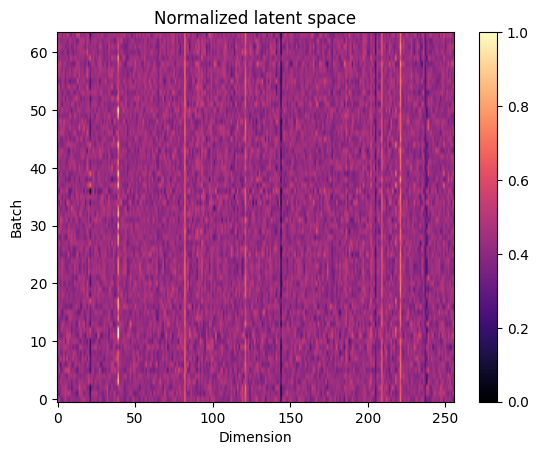

In [23]:
z_cpu = z.detach().cpu()

z_cpu = (z_cpu - z_cpu.min()) / (z_cpu.max() - z_cpu.min())

plt.imshow(z_cpu, cmap='magma', aspect='auto', origin='lower')
plt.xlabel('Dimension')
plt.ylabel('Batch')
plt.title('Normalized latent space')
plt.colorbar()
plt.show()

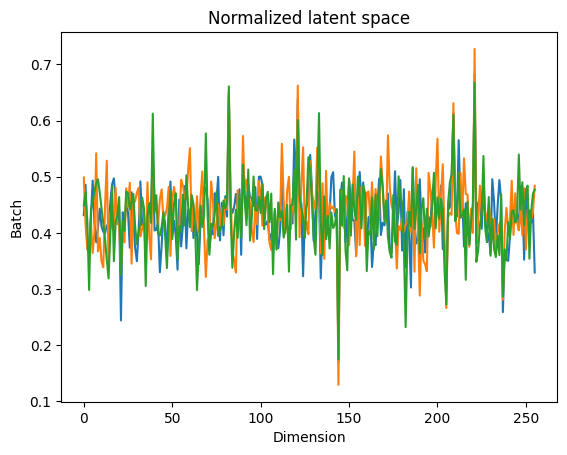

In [104]:
plt.plot(z_cpu[0,:])
plt.plot(z_cpu[25,:])
plt.plot(z_cpu[15,:])
plt.xlabel('Dimension')
plt.ylabel('Batch')
plt.title('Normalized latent space')
plt.show()

In [123]:
def _next_pow2(n: int) -> int:
    return 1 << (n - 1).bit_length()

fft = []

for i in range(64):
    x = np.asarray(z[i,:].detach().cpu())
    N = x.shape

    if nfft is None:
        nfft = _next_pow2(N)

    # FFT frequency grid
    freqs = np.fft.rfftfreq(nfft, d=1)
    X = np.fft.rfft(x, n=nfft)
    fft.append(X)

/home/jgduarte/Documents/RA/stochastic_dynamics/diffusion_model_stochastic_process/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/jgduarte/Documents/RA/stochastic_dynamics/diffusion_model_stochastic_process/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


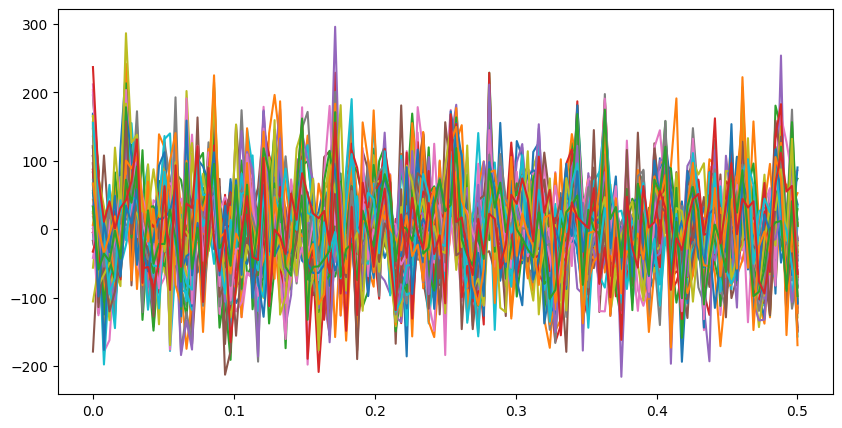

In [127]:
fig = plt.figure(figsize=(10,5))

for i in fft:
    plt.plot(freqs, i)

plt.show()

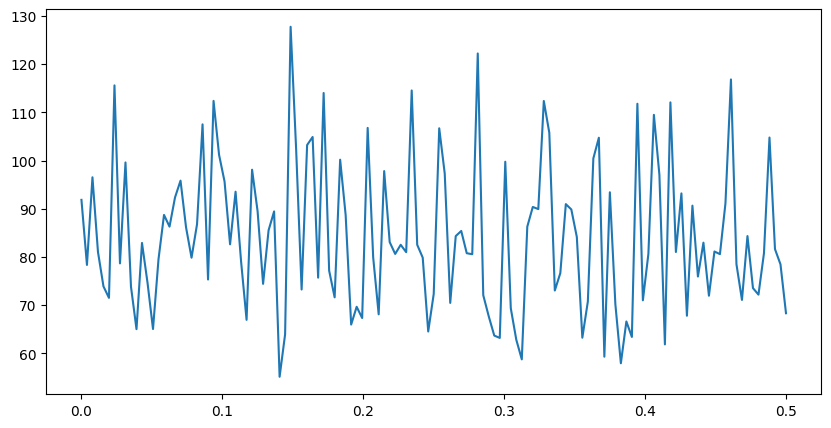

In [131]:
fig = plt.figure(figsize=(10,5))

fft_mean = np.mean(np.abs(fft), axis=0)

plt.plot(freqs, fft_mean)

plt.show()